Plot of :
    image + labels
    featureset
    (d =  average dist of all points in crack label vs gap label)
    plot of all points in img who are less than d from crack label

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.preprocessing import minmax_scale, scale

from interactive_seg_backend.file_handling import load_image, load_labels
from interactive_seg_backend.main import featurise, train_and_apply, TrainingConfig, FeatureConfig

from vulture.main import (
    get_hr_feats,
    get_dv2_model,
    get_upsampler_and_expr,
)
from vulture.utils import convert_image, to_numpy, closest_crop, Experiment, do_2D_pca, add_flash_attention

from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, chebyshev, cdist
from scipy.sparse import triu

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay


from PIL import Image
from skimage.measure import label
from skimage.color import label2rgb
import matplotlib.pyplot as plt

from typing import Any, Literal

torch.cuda.empty_cache()

SEED = 10673
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda:0"

FeatureTypes = Literal["classical", "dv2_bilinear", "hr_vit"]

N CPUS: 18


In [2]:
# normal_dv2 = get_dv2_model(fit_3d=False, device=DEVICE)
dv2 = get_dv2_model(True, device=DEVICE)

model_path = "../trained_models/e5000_fit_reg_f64.pth"
cfg_path = "../vulture/models/configs/upsampler_fewer_features.json"

upsampler, expr = get_upsampler_and_expr(model_path, cfg_path, device=DEVICE)

Using cache found in /home/ronan/.cache/torch/hub/ywyue_FiT3D_main
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_small_patch14_reg4_dinov2.lvd142m)
INFO:timm.models._hub:[timm/vit_small_patch14_reg4_dinov2.lvd142m] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [3]:
image = Image.open('fig_data/alignment/noisy_NMC_cracks.png').convert('RGB')
img_arr_l = np.array(image.convert('L'))
img_arr_rgb = np.array(image.convert('RGB'))

labels = load_labels('fig_data/alignment/local_cracks_top_before.tiff')

connected_components = label(labels)
CRACK_LABEL_IDXS = [1, 6]
GAP_LABEL_IDXS = [3, 8]

In [4]:
fc = FeatureConfig()
tc = TrainingConfig(fc)

In [5]:
@torch.no_grad()
def original_featurise(img: Image.Image, dv2: torch.nn.Module, resize: str | None="nearest", fit3d: bool=True) -> np.ndarray:
    # _img = Image.open(path).convert("RGB")
    _h, _w = img.height, img.width
    tr = closest_crop(_h, _w)

    tensor = convert_image(img, tr, device_str=DEVICE)
    print(tensor.shape)
    _, _, h, w = tensor.shape
    with torch.autocast("cuda", torch.float16):
        if fit3d:
            dino_feats = dv2.forward_features(tensor)[:, 5:, :]
        else:
            dino_feats = dv2.forward_features(tensor)['x_norm_patchtokens']
    n_patch_w, n_patch_h = w // 14, h // 14
    dino_feats = dino_feats.permute((0, 2, 1))
    dino_feats = dino_feats.reshape((1, -1, n_patch_h, n_patch_w,))
    if resize == "nearest":
        dino_feats = F.interpolate(dino_feats, (_h, _w), mode='nearest')
    elif resize == "bilinear":
        dino_feats = F.interpolate(dino_feats, (_h, _w), mode='bilinear')
    dino_feats_np = to_numpy(dino_feats)
    return dino_feats_np

In [6]:
classical_feats = featurise(img_arr_l, tc)

In [7]:
bilinear_deep = original_featurise(image, dv2, resize='bilinear', fit3d=True)

torch.Size([1, 3, 574, 672])


In [8]:
bilinear_deep_np = bilinear_deep.transpose((1, 2, 0))
bilinear_deep_np = np.concatenate((bilinear_deep_np, classical_feats), axis=-1)

In [16]:
deep_feats = get_hr_feats(image, dv2, upsampler, DEVICE, True)
deep_feats_np = to_numpy(deep_feats).transpose((1, 2, 0))
deep_feats_np = np.concatenate((deep_feats_np, classical_feats), axis=-1)

In [10]:
hybrid_feats = np.concatenate((deep_feats_np, classical_feats), axis=-1)

In [11]:
def get_inds_of_points_given_label_idxs(idxs: list[int], labels: np.ndarray) -> np.ndarray:
    out = np.ndarray((0, 2), dtype=np.int32)
    for idx in idxs:
        mask = np.argwhere(labels == idx)
        out = np.concatenate((out, mask), axis=0)
    return out

def get_sample_feats_from_idxs(feats: np.ndarray, idxs: list[int], labels: np.ndarray) -> np.ndarray:
    sampled_inds = get_inds_of_points_given_label_idxs(idxs, labels)
    sampled_feats = feats[sampled_inds[:, 0], sampled_inds[:, 1]]
    return sampled_feats


def get_average_dist(label_idxs_0: list[int], label_idxs_1: list[int], feats: np.ndarray, std_scale: bool=True) -> tuple[float, np.ndarray, np.ndarray]:
    idxs_0 = get_inds_of_points_given_label_idxs(label_idxs_0, connected_components)
    idxs_1 = get_inds_of_points_given_label_idxs(label_idxs_1, connected_components)

    feats_0 = feats[idxs_0[:, 0], idxs_0[:, 1]]
    feats_1 = feats[idxs_1[:, 0], idxs_1[:, 1]]

    if std_scale:
        feats_0 = scale(feats_0)
        feats_1 = scale(feats_1)
    
    dists = cdist(feats_0, feats_1, "chebyshev")
    return np.mean(dists), np.mean(feats_0, axis=0), np.mean(feats_1, axis=0)


NormTypes = Literal[None, "minmax", "std"]
def pca_feats(feats: np.ndarray, k: int, pre_norm: NormTypes=None, post_norm: NormTypes=None, swap_channel_ax: bool=False, n_samples: int=0, reshape_to_2D:bool=False) -> tuple[PCA, np.ndarray]:
    
    h, w = None, None
    is_2d = len(feats.shape) == 3 
    if is_2d:
        if swap_channel_ax:
            feats = feats.transpose((1, 2, 0))
        h, w, c = feats.shape
        feats = feats.reshape((h * w, c))
    
    if pre_norm  == "minmax":
        feats = minmax_scale(feats)
    elif pre_norm == "std":
        feats = scale(feats)

    feats = np.nan_to_num(feats, nan=0.0)
    if n_samples > 0:
        np.random.shuffle(feats)
        feats = feats[:n_samples]

    pca = PCA(n_components=k)
    res = pca.fit_transform(feats)

    if post_norm  == "minmax":
        res = minmax_scale(res)
    elif post_norm == "std":
        res = scale(res)
    
    if reshape_to_2D and is_2d:
        assert h and w
        res = res.reshape((h, w, -1))
    
    return pca, res


def apply_pca(feats: np.ndarray, pca_: PCA, pre_norm: NormTypes=None, post_norm: NormTypes=None, swap_channel_ax: bool=False, reshape_to_2D:bool=False) -> np.ndarray:
    h, w = None, None
    is_2d = len(feats.shape) == 3 
    if is_2d:
        if swap_channel_ax:
            feats = feats.transpose((1, 2, 0))
        h, w, c = feats.shape
        feats = feats.reshape((h * w, c))
    
    if pre_norm  == "minmax":
        feats = minmax_scale(feats)
    elif pre_norm == "std":
        feats = scale(feats)

    feats = np.nan_to_num(feats, nan=0.0)
    res = pca_.transform(feats)

    if post_norm  == "minmax":
        res = minmax_scale(res)
    elif post_norm == "std":
        res = scale(res)
    
    if reshape_to_2D and is_2d:
        assert h and w
        res = res.reshape((h, w, -1))
    return res

SVCKernel = Literal['linear', 'poly', 'rbf']
def fit_svc(kind: SVCKernel, feats_0: np.ndarray, feats_1: np.ndarray, ) -> SVC:
    labels_0 = np.zeros((feats_0.shape[0]))
    labels_1 = np.ones((feats_1.shape[0]))

    training_data = np.concatenate((feats_0, feats_1))
    target_data = np.concatenate((labels_0, labels_1))

    svc = SVC(kernel=kind)
    svc.fit(training_data, target_data)

    return svc

In [12]:
results = {}
PCA_ALL: bool = False
for name, feats in zip(("classical", "bilinear", "deep",), (classical_feats, bilinear_deep_np,  deep_feats_np)):
    results[name] = {}
    if PCA_ALL:
        pca_, tmp =  pca_feats(feats, 2, None, None, reshape_to_2D=True)
    else:
        tmp = feats


    gap_feats = get_sample_feats_from_idxs(tmp, GAP_LABEL_IDXS, connected_components)
    crack_feats = get_sample_feats_from_idxs(tmp, CRACK_LABEL_IDXS, connected_components)
    n_gap = gap_feats.shape[0]

    labels_0 = np.zeros((n_gap))
    labels_1 = np.ones((crack_feats.shape[0]))

    all_feats = np.concatenate((gap_feats, crack_feats))
    target_data = np.concatenate((labels_0, labels_1))

    if PCA_ALL is False:
        pca_, pcaed = pca_feats(all_feats, 2, 'std', 'minmax', False)
    else:
        pcaed = all_feats

    svc = fit_svc('rbf', pcaed[:n_gap], pcaed[n_gap:])

    results[name]["SVC"] = svc
    results[name]["gap_feats"] = pcaed[:n_gap]
    results[name]["crack_feats"] = pcaed[n_gap:]
    results[name]["training_data"] = pcaed
    results[name]["target_data"] = target_data
    results[name]["pca"] = pca_
    # print(feats.shape)
    # results[name]["all_feats_pcaed"] = pca.transform(feats)

In [13]:
gt = load_labels("fig_data/alignment/gt.tiff")
GAP_CLASS_IDX, CRACK_CLASS_IDX = 1, 2


0.7142857142857143
0.9265657326246993
0.9327731092436975
0.005227028489132898
0.927170868347339
0.00501502313782541


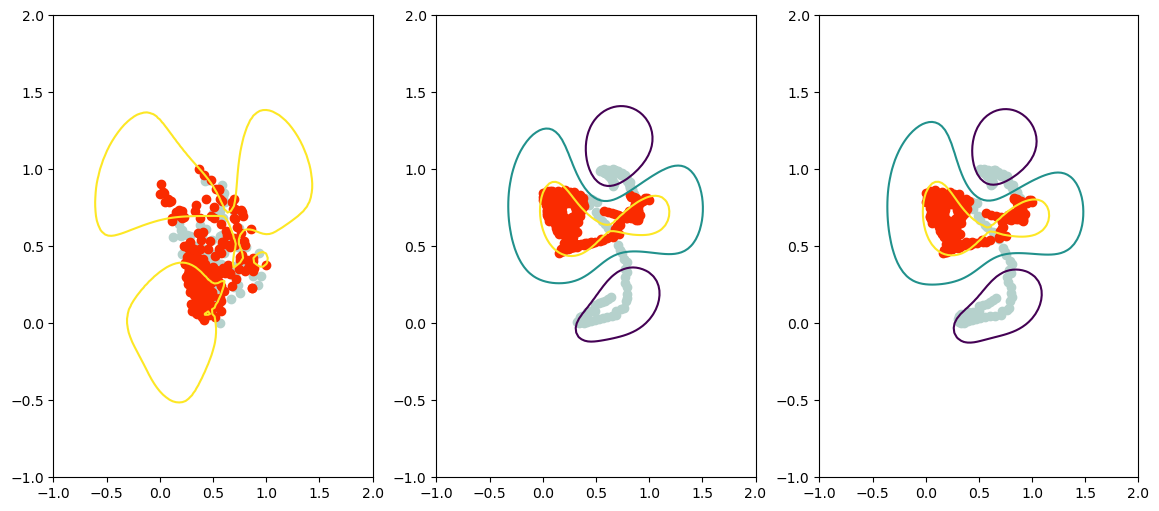

In [15]:
fig, axs = plt.subplots(ncols=len(results.keys()), figsize=(14, 6))
GAP_COLOUR = "#b5d1cc"
CRACK_COLOUR = "#fa2b00"

for i, (name, feats) in enumerate(zip(("classical", "bilinear", "deep"), (classical_feats,  bilinear_deep_np,  deep_feats_np))):
    ax = axs[i]
    svc: SVC = results[name]["SVC"]
    data = results[name]["training_data"]
    gap_feats, crack_feats = results[name]["gap_feats"], results[name]["crack_feats"]

    pca_: PCA = results[name]["pca"]
    all_feats_pca = apply_pca(feats, pca_, 'std', 'minimax', False, True)
    all_crack_data = all_feats_pca[gt == CRACK_CLASS_IDX]
    all_gap_data = all_feats_pca[gt == GAP_CLASS_IDX]

    all_crack_targ = np.zeros(all_crack_data.shape[0]) + CRACK_CLASS_IDX
    all_gap_targ = np.zeros(all_gap_data.shape[0]) + GAP_CLASS_IDX
    # print(all_crack_data.shape, all_gap_da)

    eval_train = np.concatenate((all_crack_data, all_gap_data), 0)
    eval_targ = np.concatenate((all_crack_targ, all_gap_targ))

    print(svc.score(data, results[name]["target_data"]))
    print(svc.score(eval_train, eval_targ))
    DecisionBoundaryDisplay.from_estimator(svc, data,ax=ax, plot_method='contour', response_method='decision_function', levels=[-1, 0, 1], alpha=1)
    

    # ax.scatter(all_gap_data[:, 0], all_gap_data[:, 1], color=GAP_COLOUR, marker='x', alpha=0.1)
    # ax.scatter(all_crack_data[:, 0], all_crack_data[:, 1], color=CRACK_COLOUR, marker='x', alpha=0.1)

    ax.scatter(gap_feats[:, 0], gap_feats[:, 1], color=GAP_COLOUR)
    ax.scatter(crack_feats[:,0], crack_feats[:, 1], color=CRACK_COLOUR)

    ax.set_xlim((-0.5, 2))
    ax.set_ylim((-0.5, 2))
# plt.tight_layout
